In [1]:
import numpy as np
# extract training and validation data from the first 5 categories: 
with open(r"category_filenames.txt") as f:
    file_names = [line.strip() for line in f]
file_names = file_names[:5]
num_cat = 5
x = np.empty((0, 28, 28, 1))
y = np.empty((0,num_cat))
for i in range(num_cat):
    file = file_names[i]
    print("Processing " + file)
    # Append the data to x
    data = np.load(file=r"doodles/" + file)
    data = data.reshape((data.shape[0], 28, 28, 1))
    if data.shape[0] > 40000:
        data = data[:40000]
    else: 
        raise Exception("One of the data categories has less than 40000 pictures")
    x = np.vstack((x, data))
    # Append the labels to y with the ones set correctly
    label = np.zeros((data.shape[0], num_cat))
    label[:, i] = 1
    y = np.vstack((y, label))
print("The shape of x is ", x.shape, "and the shape of y is ", y.shape)
# Shuffle x and y randomly (but equally) such that all categories are used as training, validation, and test data
permut = np.random.permutation(x.shape[0])
x = x[permut]
y = y[permut]
num_train = (x.shape[0] * 9) // 10    # use 90% of data set for training
num_validation = x.shape[0] - num_train # use 10% of data set for validation
print("Number of training data: ",num_train)
print("Number of validation data: ",num_validation)
x_train = x[0:num_train]
y_train = y[0:num_train]
x_validation = x[num_train:]
y_validation = y[num_train:]
print("The shape of the training data is : ", (x_train.shape,y_train.shape))
print("The shape of the validation data is : ",(x_validation.shape, y_validation.shape))

Processing full_numpy_bitmap_airplane.npy
Processing full_numpy_bitmap_alarm clock.npy
Processing full_numpy_bitmap_axe.npy
Processing full_numpy_bitmap_banana.npy
Processing full_numpy_bitmap_bicycle.npy
The shape of x is  (200000, 28, 28, 1) and the shape of y is  (200000, 5)
Number of training data:  180000
Number of validation data:  20000
The shape of the training data is :  ((180000, 28, 28, 1), (180000, 5))
The shape of the validation data is :  ((20000, 28, 28, 1), (20000, 5))


Flattening the training data.
New shape:  (180000, 784)
Fitting a pca to the training data.


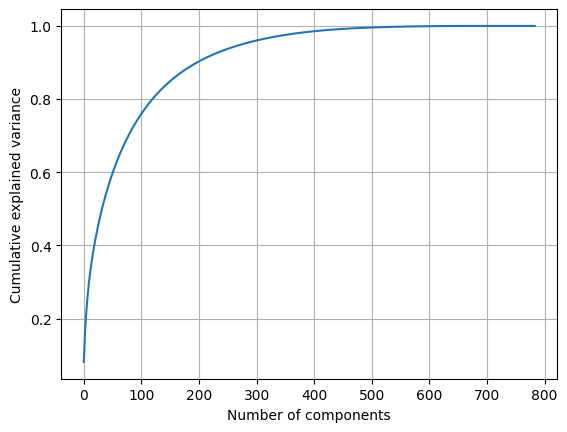

In [2]:
from sklearn.decomposition import PCA
print("Flattening the training data.")
x_train_flat = x_train.reshape(x_train.shape[0],-1)
print("New shape: ",x_train_flat.shape)
print("Fitting a pca to the training data.")
pca_full = PCA().fit(x_train_flat)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
import matplotlib.pyplot as plt
plt.plot(cumulative_variance)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.show()

In [3]:
# based on the above graph, it looks like 200 components explain enough of the variance. 
pca_final = PCA(n_components=200)
x_train_reduced = pca_final.fit_transform(x_train_flat)

In [7]:
savepca = False
if savepca == True:
    # save the pca:
    import joblib
    # Save
    joblib.dump(pca_final, "pca_final_model.pkl")

2025-07-13 22:48:43.099677: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


setting up the model:
Training a fully connected neural network on data reduced by PCA.
First, need to reduce dimensionality of validation data.
Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7046 - loss: 12.7756 - val_accuracy: 0.8548 - val_loss: 0.4615
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8315 - loss: 0.5589 - val_accuracy: 0.8976 - val_loss: 0.3309
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8738 - loss: 0.4108 - val_accuracy: 0.9091 - val_loss: 0.2855
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8939 - loss: 0.3450 - val_accuracy: 0.9189 - val_loss: 0.2553
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9054 - loss: 0.3069 - val_accuracy: 0.9271 - val_loss: 0.2310
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9139 - loss: 0.2803 - val_accuracy: 0.9305 - val_loss: 0.2170
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9197 -

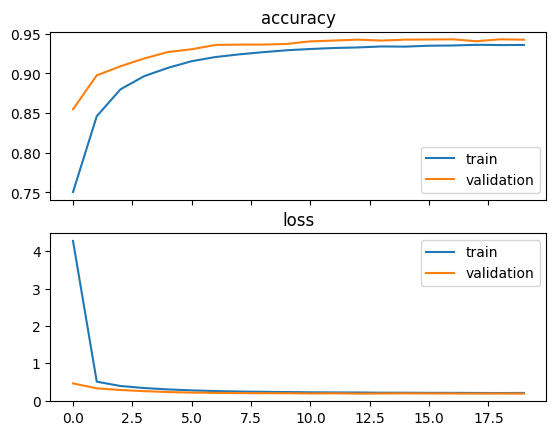

In [9]:
train = True
if train == True:
    from tensorflow import keras
    print("setting up the model:")
    model = keras.models.Sequential()
    model.add(keras.Input(shape = (200,))) # the transformed images have 200 features
    model.add(keras.layers.Dense(units=128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units=128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units= num_cat, activation='softmax'))  # num_cat = 5, softmax guarantees a prob distribution as output
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    print("Training a fully connected neural network on data reduced by PCA.")
    print("First, need to reduce dimensionality of validation data.")
    x_validation_flat = x_validation.reshape(x_validation.shape[0],-1)
    x_validation_reduced = pca_final.transform(x_validation_flat)
    hist = model.fit(x_train_reduced, y_train, batch_size=128, epochs = 20, verbose=1, validation_data=(x_validation_reduced, y_validation))
    def plot_history(history):
        x = range(history.params['epochs'])
        acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
        f, axarr = plt.subplots(2, sharex=True)
        axarr[0].set_title('accuracy')
        axarr[0].plot(x, acc, label='train')
        axarr[0].plot(x, val_acc, label='validation')
        axarr[0].legend()
        loss, val_loss = history.history['loss'], history.history['val_loss']
        axarr[1].set_title('loss')
        axarr[1].plot(x, loss, label='train')
        axarr[1].plot(x, val_loss, label='validation')
        axarr[1].legend()
        plt.show()
        return
    plot_history(hist)
savenn = False
if savenn == True:
    # save the weights:
    model.save_weights("pca_architecturetype2.weights.h5")

In [10]:
eigendoodles_final = pca_final.components_

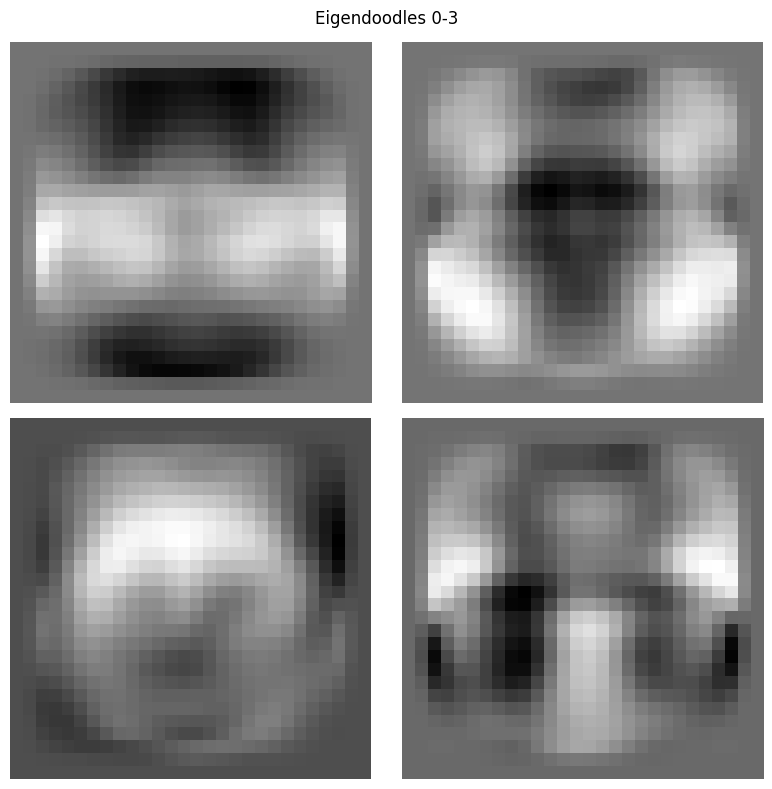

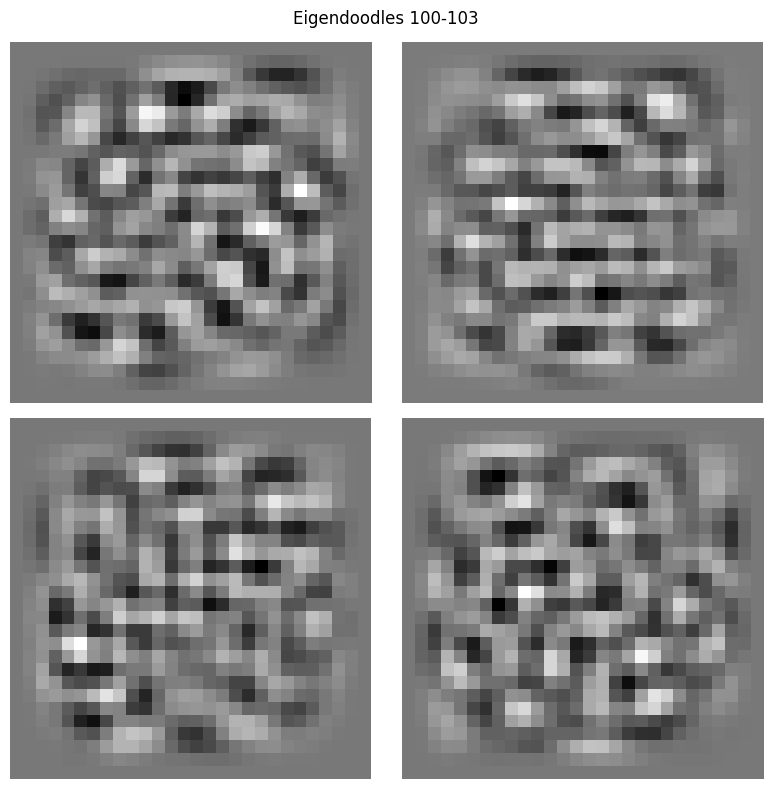

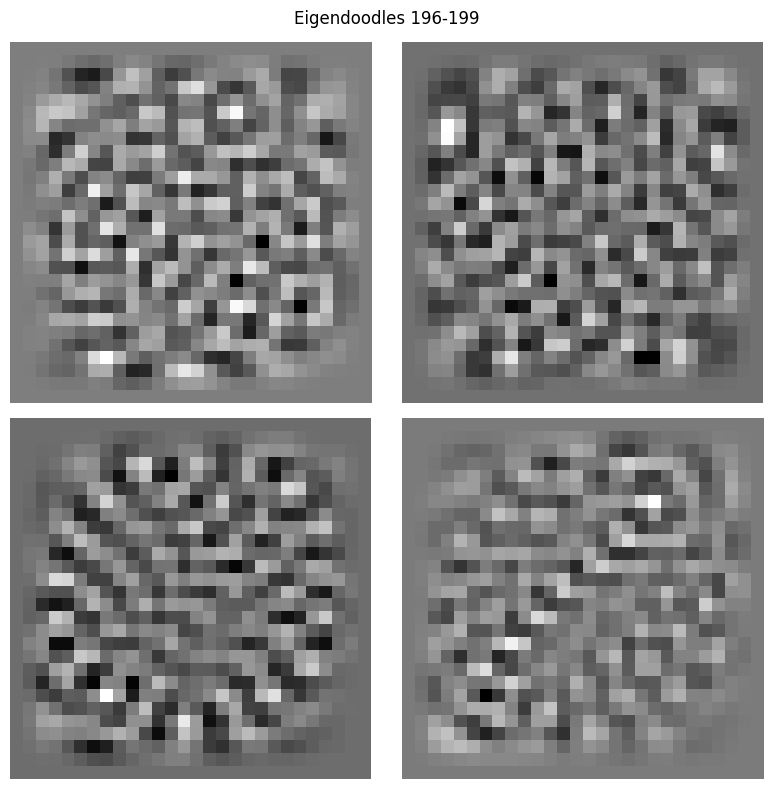

In [11]:
# plot some eigendoodles:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle("Eigendoodles 0-3")
for i in range(2):
    for j in range(2):
        index = i * 2 + j
        axes[i, j].imshow(eigendoodles_final[index].reshape(28,28), cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle("Eigendoodles 100-103")
for i in range(2):
    for j in range(2):
        index = i * 2 + j
        axes[i, j].imshow(eigendoodles_final[index+100].reshape(28,28), cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle("Eigendoodles 196-199")
for i in range(2):
    for j in range(2):
        index = i * 2 + j
        axes[i, j].imshow(eigendoodles_final[-4+index].reshape(28,28), cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()